In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [11]:
trades = pd.read_csv("expiry_trades.csv", parse_dates=["date"])
trades.head()

,date,direction,entry_time,entry_price,exit_time,exit_price,return
0,2025-05-22,long,09:30:00,275.519989,15:15:00,275.929993,0.001488
1,2025-06-05,short,09:30:00,277.500000,15:15:00,277.890015,-0.001405
2,2025-06-26,short,09:30:00,284.489990,15:15:00,286.299988,-0.006362


In [12]:
# trades['entry_time'] = pd.to_datetime(trades['entry_time'], format="%H:%M:%S").dt.time
# trades['exit_time'] = pd.to_datetime(trades['exit_time'], format="%H:%M:%S").dt.time
trades['outcome'] = trades['return'].apply(lambda x: 'Win' if x > 0 else 'Loss')
trades['cum_return'] = (1 + trades['return']).cumprod()

In [13]:
summary = {
    "Total Trades": len(trades),
    "Winning Trades": (trades['return'] > 0).sum(),
    "Losing Trades": (trades['return'] <= 0).sum(),
    "Win Rate (%)": 100 * (trades['return'] > 0).mean(),
    "Average Return (%)": 100 * trades['return'].mean(),
    "Std Dev (%)": 100 * trades['return'].std(),
    "Max Return (%)": 100 * trades['return'].max(),
    "Min Return (%)": 100 * trades['return'].min(),
    "Cumulative Return (multiplier)": trades['cum_return'].iloc[-1] if not trades.empty else 1.0,
    "Sharpe Ratio (naive)": trades['return'].mean() / trades['return'].std() if trades['return'].std() > 0 else None
}

pd.DataFrame.from_dict(summary, orient='index', columns=["Value"])


,Value
Total Trades,3.000000
Winning Trades,1.000000
Losing Trades,2.000000
Win Rate (%),33.333333
Average Return (%),-0.209320
Std Dev (%),0.397011
Max Return (%),0.148811
Min Return (%),-0.636225
Cumulative Return (multiplier),0.993718
Sharpe Ratio (naive),-0.527240


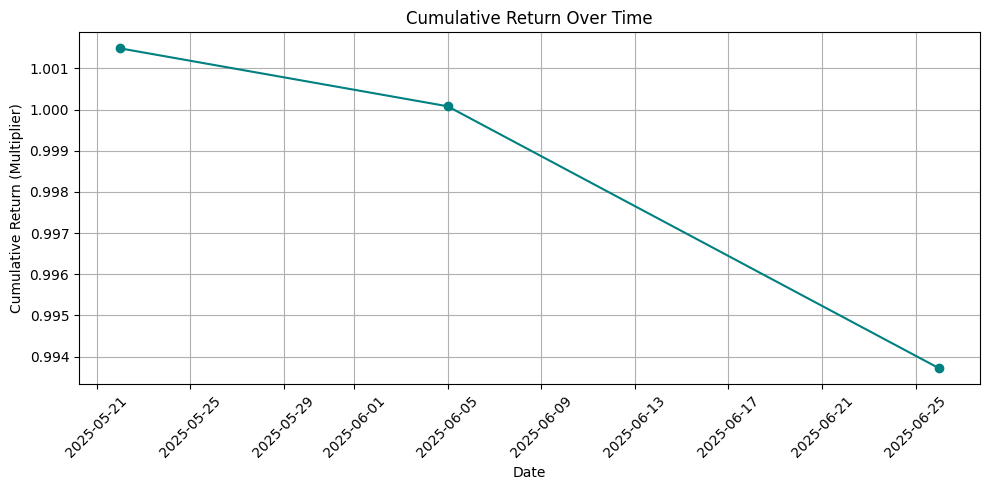

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(trades['date'], trades['cum_return'], marker='o', linestyle='-', color='teal')
plt.title("Cumulative Return Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Multiplier)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


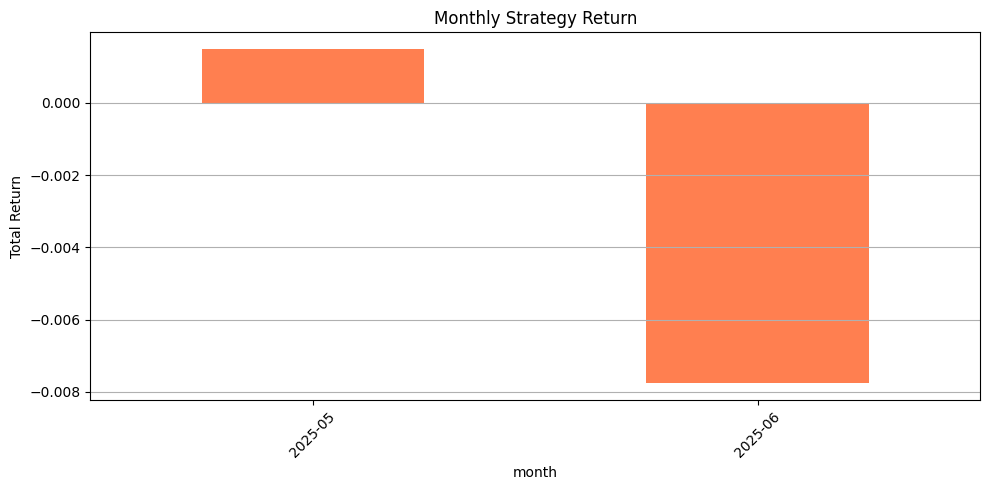

In [15]:
trades['month'] = trades['date'].dt.to_period('M')
monthly_perf = trades.groupby('month')['return'].sum()

plt.figure(figsize=(10, 5))
monthly_perf.plot(kind='bar', color='coral')
plt.title("Monthly Strategy Return")
plt.ylabel("Total Return")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [16]:
direction_perf = trades.groupby('direction')['return'].agg(['count', 'mean', 'sum', 'std'])

print("Performance by Trade Direction:")
display(direction_perf)

Performance by Trade Direction:


,count,mean,sum,std
direction,,,,
long,1,0.001488,0.001488,NaN
short,2,-0.003884,-0.007768,0.003505


In [17]:
thresholds = [0.001, 0.002, 0.003, 0.004, 0.005]

sensitivity = []

for t in thresholds:
    filtered = trades[trades['return'].abs() > t]
    sensitivity.append({
        'Threshold': t,
        'Trades': len(filtered),
        'Mean Return': filtered['return'].mean(),
        'Win Rate': (filtered['return'] > 0).mean(),
        'Cumulative Return': (1 + filtered['return']).prod()
    })

pd.DataFrame(sensitivity)


,Threshold,Trades,Mean Return,Win Rate,Cumulative Return
0,0.001,3,-0.002093,0.333333,0.993718
1,0.002,1,-0.006362,0.000000,0.993638
2,0.003,1,-0.006362,0.000000,0.993638
3,0.004,1,-0.006362,0.000000,0.993638
4,0.005,1,-0.006362,0.000000,0.993638
